In [159]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import sounddevice as sd
import zplane as zp
import scipy.signal as signal
import yulewalker as yw

In [160]:
letters = [
    ['A1', 'A2'],
    ['I1', 'I2'],
]

In [161]:
def fft(y: np.array, fs: int) -> (np.array, np.array, float):
    N = len(y)
    ys = np.fft.fft(y)[:N//2]
    freq = np.linspace(0, fs, N)[:N//2]
    base_freq = freq[np.argmax(np.abs(ys))]
    return ys, freq, base_freq

In [162]:
def comb_filter(y: np.array, fs: int, base_freq: float, harmonics: np.array):
    np.int = np.int64
    band_stop_width = 30
    transition_width = 3

    fc = np.array([0])
    am = np.array([1])
    nyq = fs / 2
    fo = 25

    for harmonic in harmonics:
        jump = 1
        while True:
            harmonic_freq = harmonic * base_freq * jump
            if harmonic_freq > nyq:
                break
            f1 = (harmonic_freq - band_stop_width - transition_width) / nyq
            f2 = (harmonic_freq - band_stop_width) / nyq
            f3 = (harmonic_freq + band_stop_width) / nyq
            f4 = (harmonic_freq + band_stop_width + transition_width) / nyq

            fc = np.concatenate((fc, [f1, f2, f3, f4]))
            am = np.concatenate((am, [1,  0,  0,  1]))

            jump = jump + 6

    fc = np.concatenate((fc, [1]))
    am = np.concatenate((am, [1]))

    sorted = np.argsort(fc)
    fc = fc[sorted]
    am = am[sorted]

    a, b = yw.yulewalk(fo, fc, am)
    w, h = signal.freqz(b, a)
    fr = w * nyq / np.pi

    yf = signal.filtfilt(b, a, y)

    return yf, fr, h, fc, am

In [163]:
def cascade_filter(y: np.array, fs: int, base_freq: float, harmonics: np.array):
    np.int = np.int64
    band_stop_width = 10
    nyq = fs / 2
    fo = 15

    sos_filters = []

    for harmonic in harmonics:
        harmonic_freq = harmonic * base_freq
        if harmonic_freq - band_stop_width <= 0 or harmonic_freq + band_stop_width >= nyq:
            continue

        f_low = (harmonic_freq - band_stop_width) / nyq
        f_high = (harmonic_freq + band_stop_width) / nyq
        sos = signal.iirfilter(fo, [f_low, f_high], btype='bandstop', ftype='butter', output='sos')
        sos_filters.append(sos)

    sos_combined = np.concatenate(sos_filters, axis=0)

    b, a = signal.sos2tf(sos_combined)
    w, h = signal.freqz_sos(sos_combined)
    fr = w * nyq / np.pi
    yf = signal.sosfiltfilt(sos_combined, y)

    return yf, fr, h

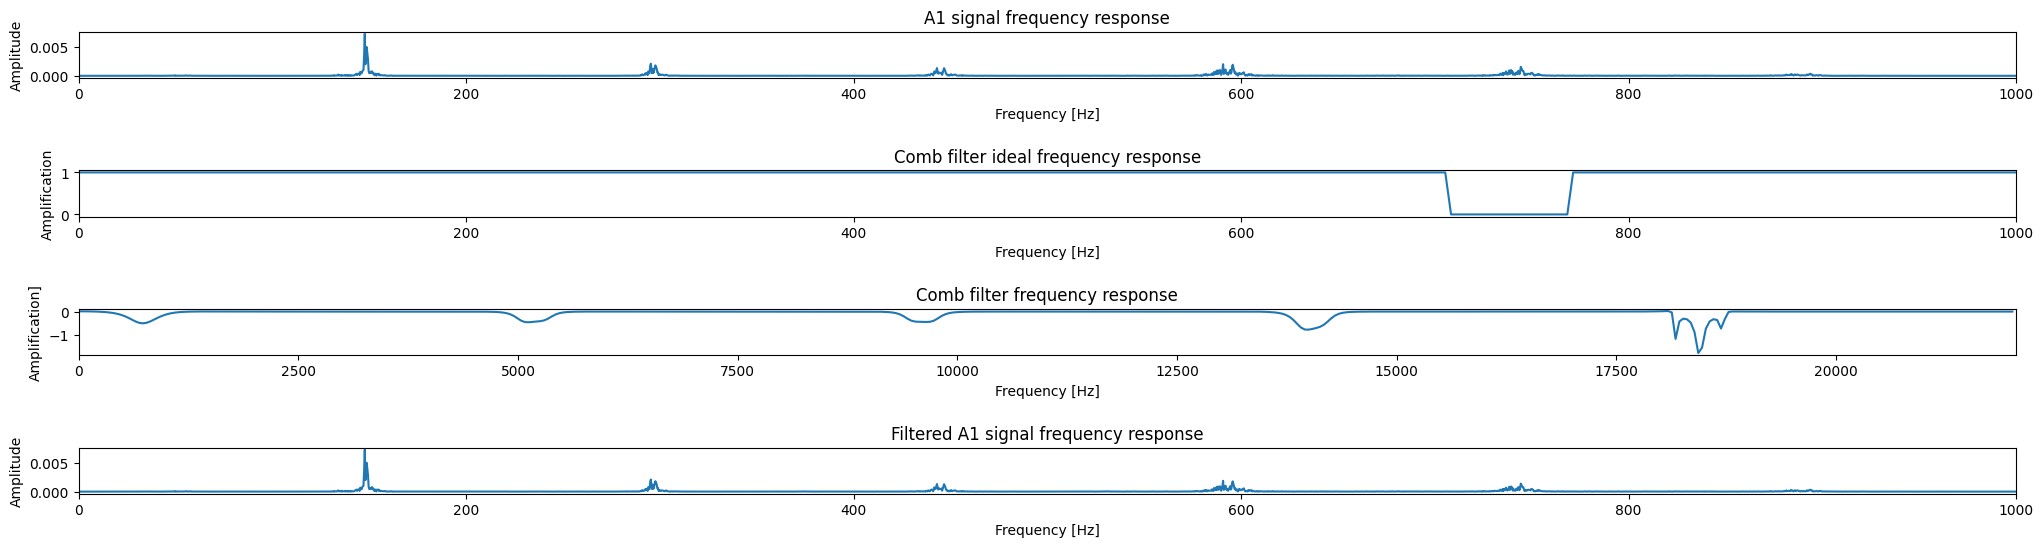

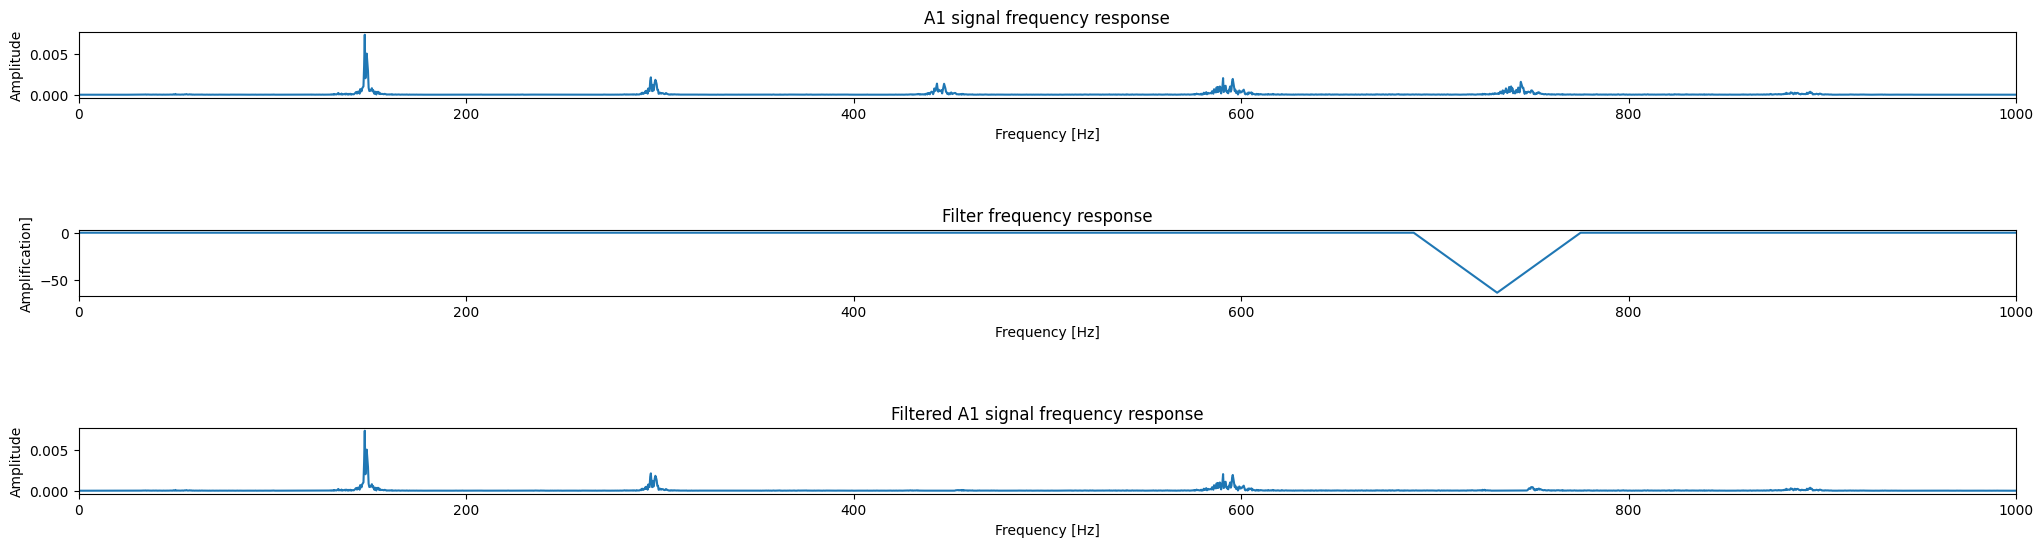

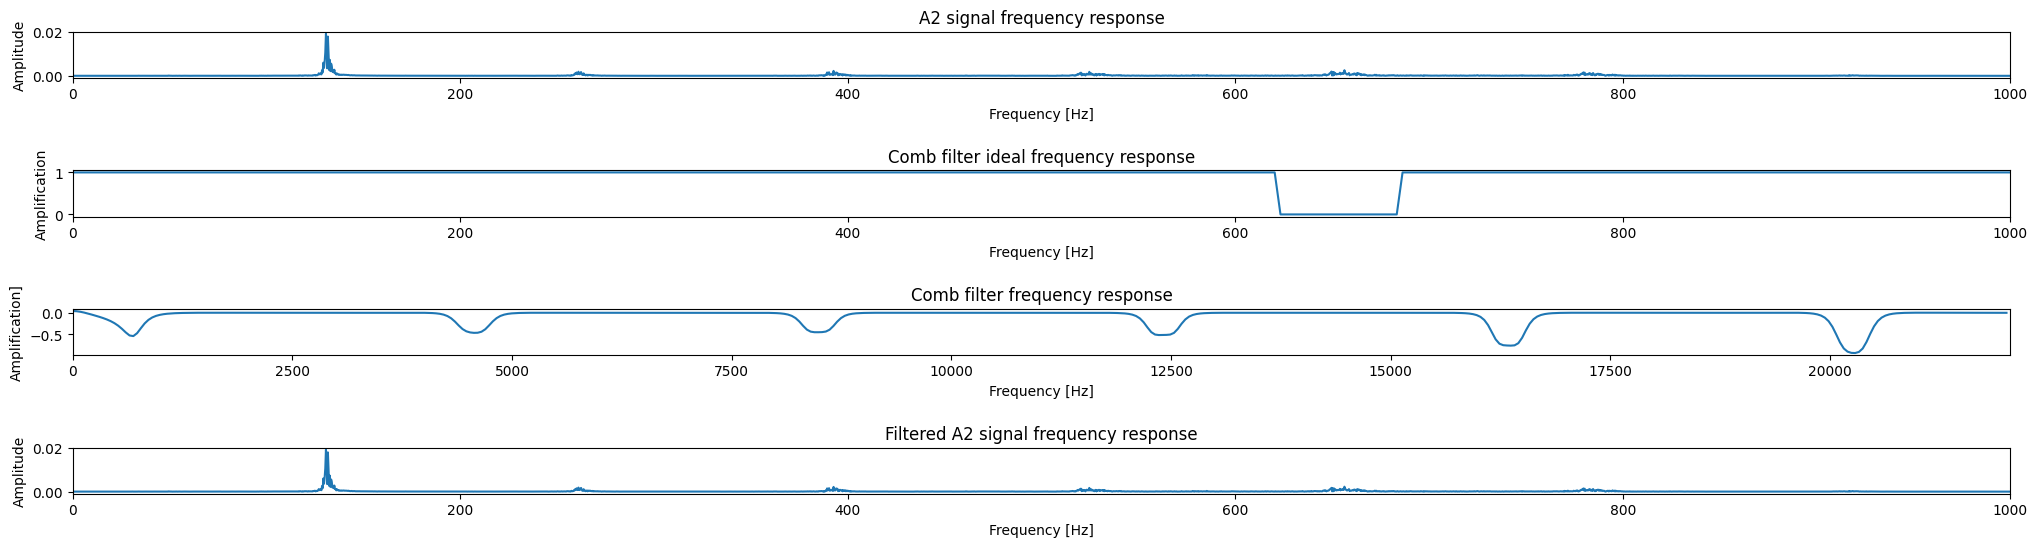

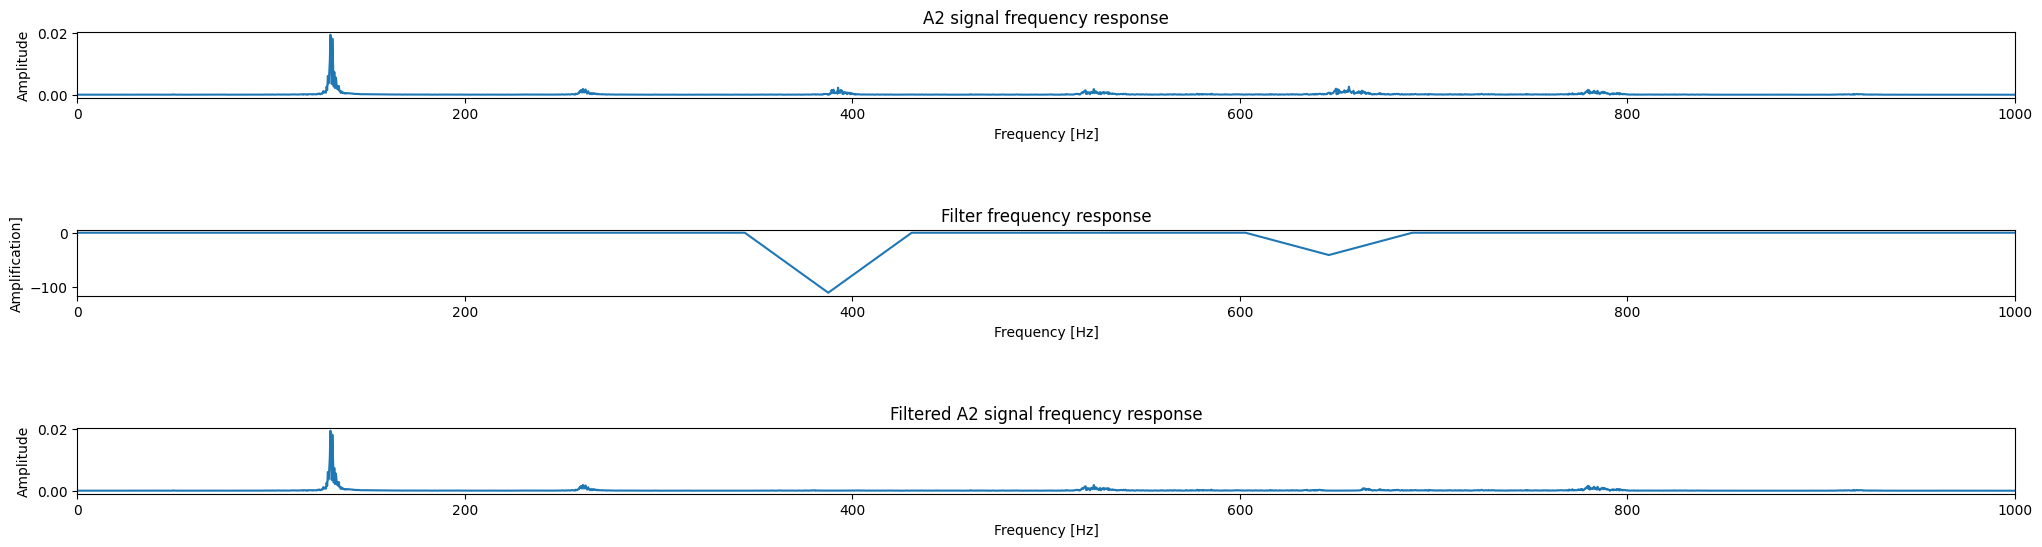

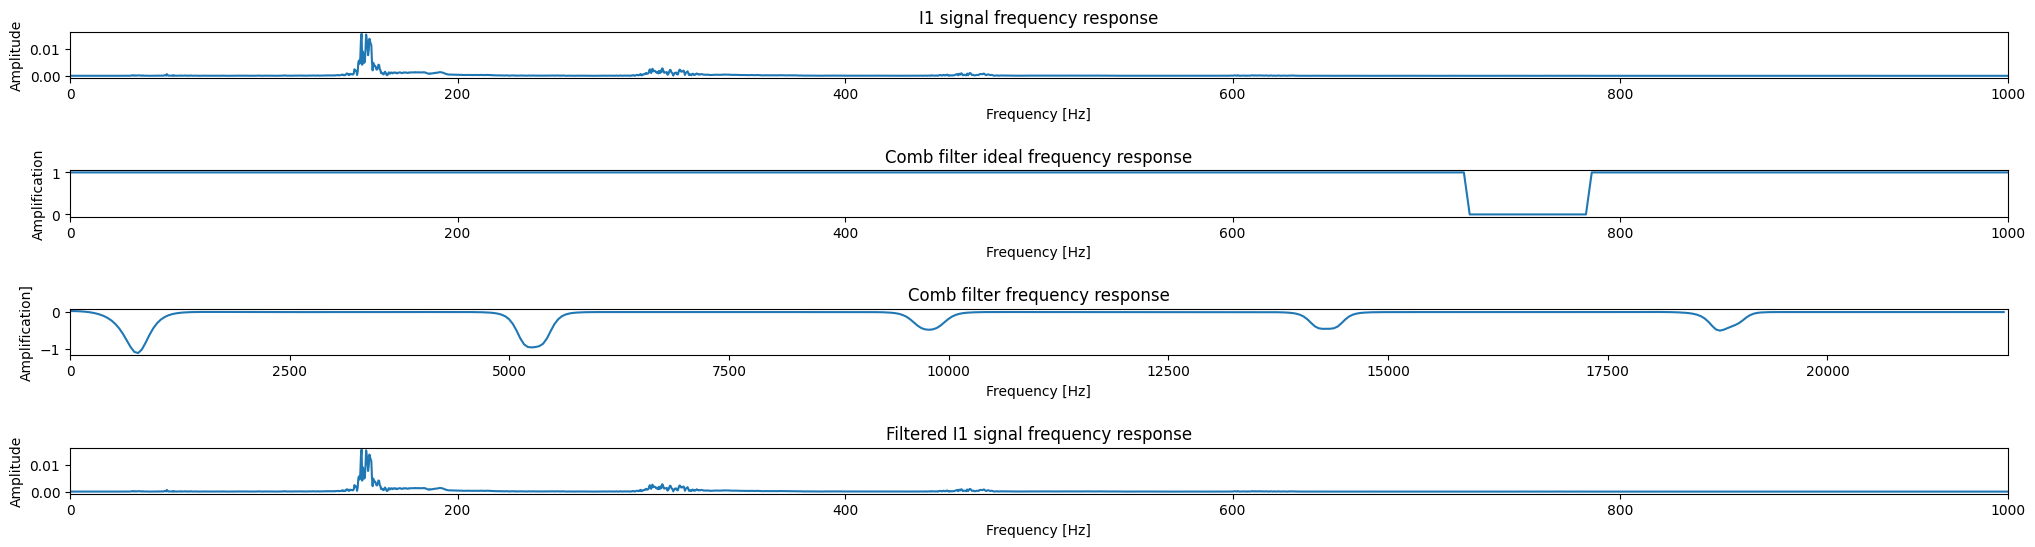

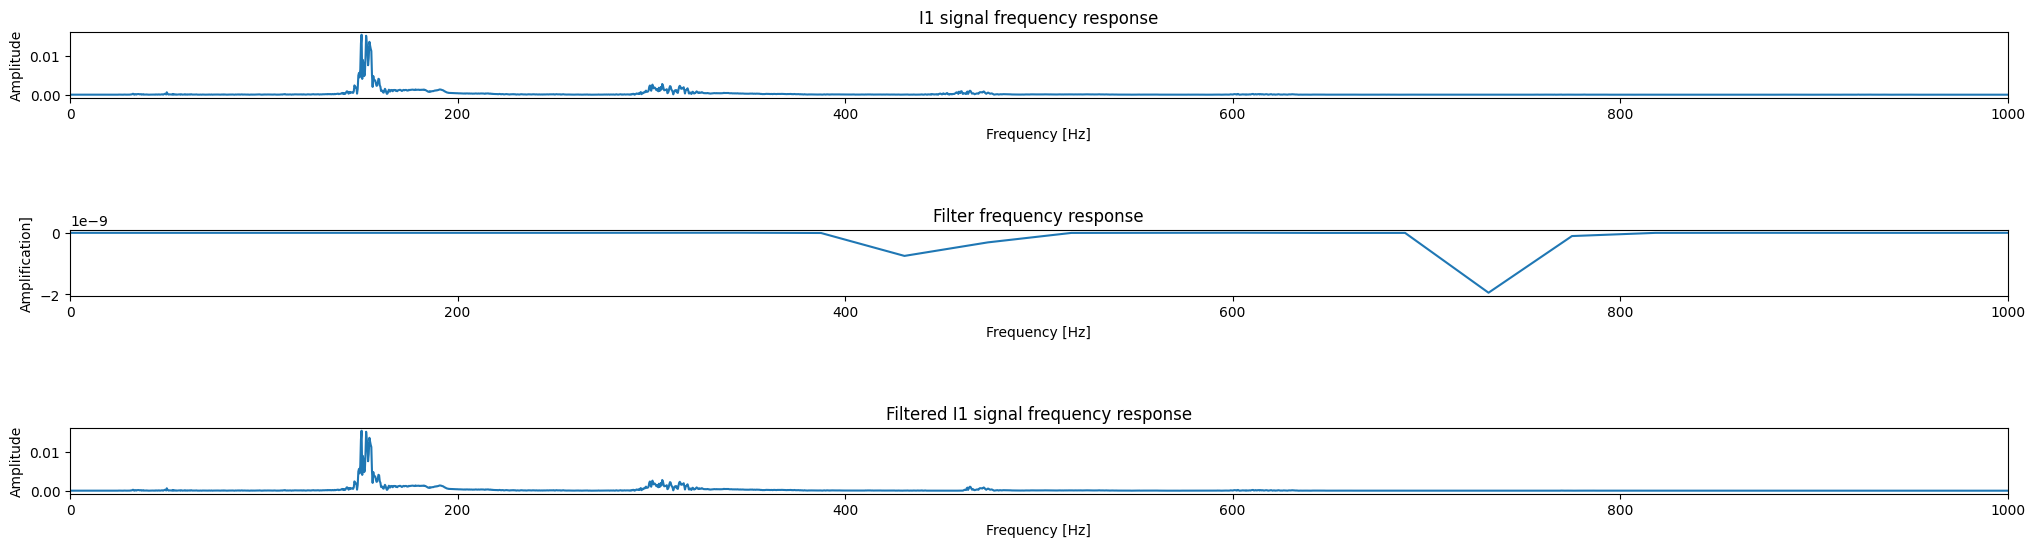

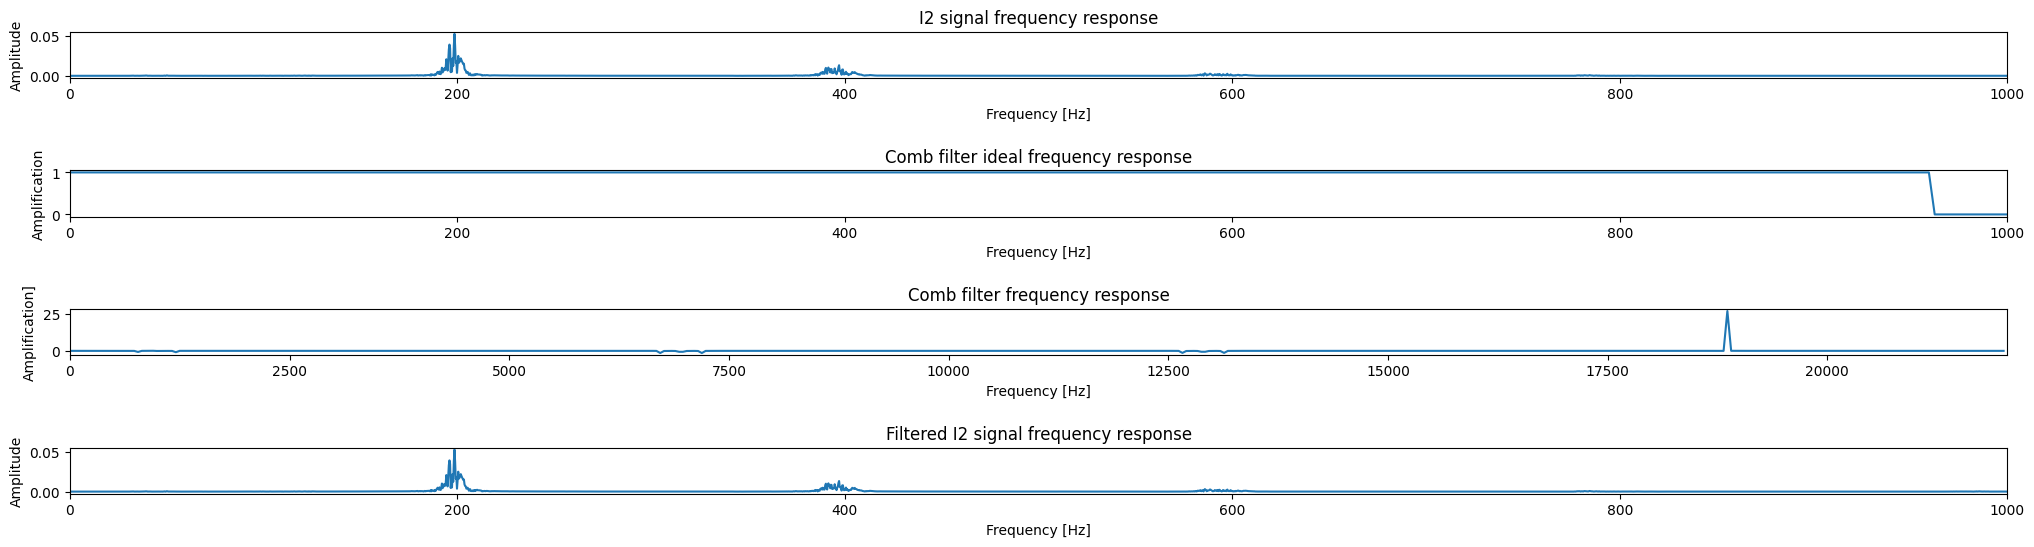

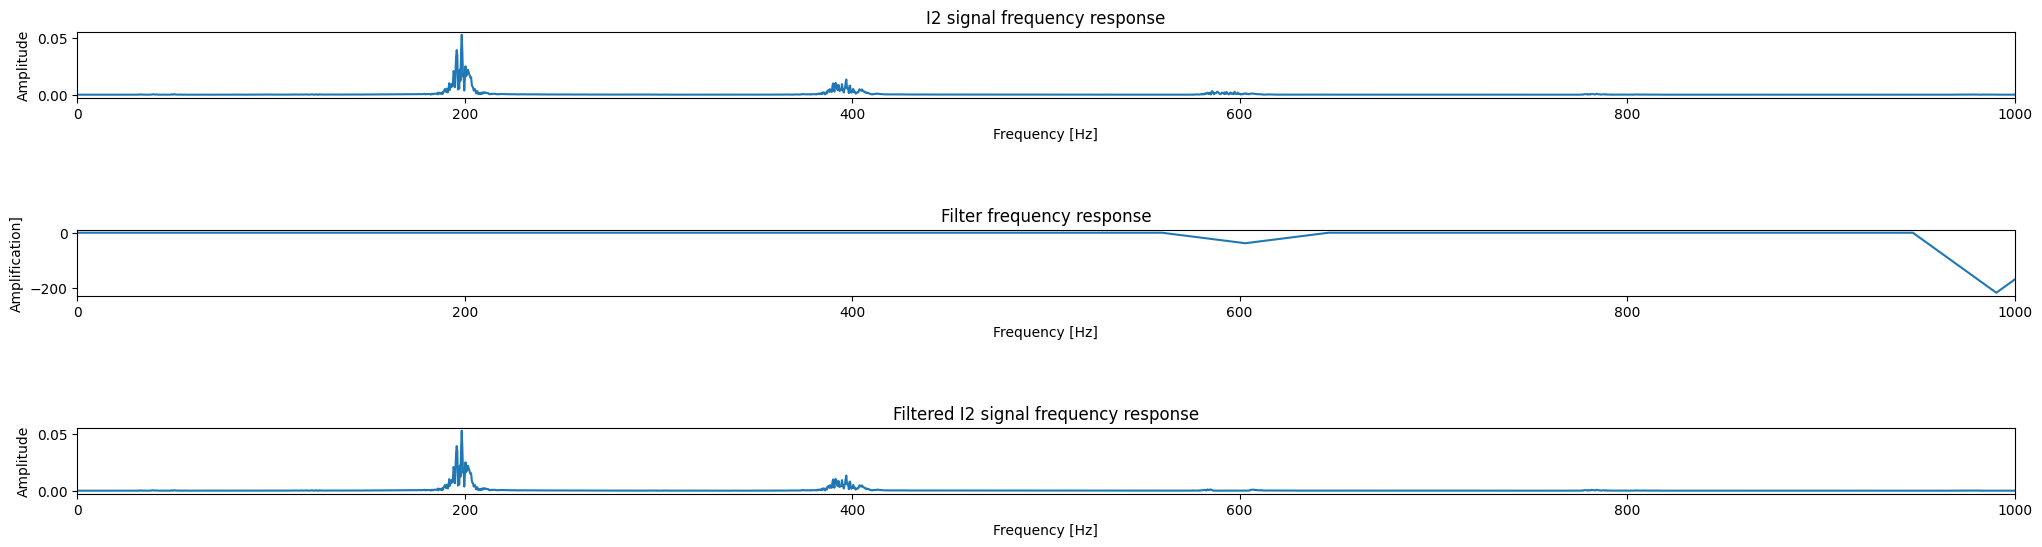

In [164]:
harmonics_to_filter_comb = np.array([5])
harmonics_to_filter_cascade = np.array([3, 5])
for letter_files in letters:
    for file in letter_files:
        y, fs = sf.read(f'data/{file}.wav')
        x_lim = 1000
        N = len(y)
        T = N / fs
        t = np.arange(0, T, 1/fs)

        ys, y_freq, y_base_freq = fft(y, fs)
        yf, fr, h, fc, am = comb_filter(y=y, fs=fs, base_freq=y_base_freq, harmonics=harmonics_to_filter_comb)

        yfs, yf_freq, yf_base_freq = fft(yf, fs)

        fig, axs = plt.subplots(nrows=4, ncols=1, gridspec_kw={'hspace': 2})
        fig.set_size_inches(25, 6)
        axs[0].plot(y_freq, np.abs(ys) / N)
        axs[0].set_title(f"{file} signal frequency response")
        axs[0].set_xlabel(f"Frequency [Hz]")
        axs[0].set_ylabel(f"Amplitude")
        axs[0].set_xlim(0, x_lim)

        axs[1].plot(fc * (fs / 2), am)
        axs[1].set_title(f"{file} Comb filter ideal frequency response")
        axs[1].set_xlabel("Frequency [Hz]")
        axs[1].set_ylabel("Amplification")
        axs[1].set_xlim(0, x_lim)

        axs[2].plot(fr, 20 * np.log10(np.abs(h)))
        axs[2].set_title(f"{file} Comb filter frequency response")
        axs[2].set_xlabel("Frequency [Hz]")
        axs[2].set_ylabel("Amplification]")
        axs[2].set_xlim(0, fs//2)

        axs[3].plot(yf_freq, np.abs(yfs) / N)
        axs[3].set_title(f"Filtered {file} signal frequency response")
        axs[3].set_xlabel(f"Frequency [Hz]")
        axs[3].set_ylabel(f"Amplitude")
        axs[3].set_xlim(0, x_lim)
        plt.show()
        print("=" * 200)
        yf, fr, h = cascade_filter(y=y, fs=fs, base_freq=y_base_freq, harmonics=harmonics_to_filter_cascade)
        yfs, yf_freq, yf_base_freq = fft(yf, fs)

        fig, axs = plt.subplots(nrows=3, ncols=1, gridspec_kw={'hspace': 2})
        fig.set_size_inches(25, 6)
        axs[0].plot(y_freq, np.abs(ys) / N)
        axs[0].set_title(f"{file} signal frequency response")
        axs[0].set_xlabel(f"Frequency [Hz]")
        axs[0].set_ylabel(f"Amplitude")
        axs[0].set_xlim(0, x_lim)

        axs[1].plot(fr, 20 * np.log10(np.abs(h)))
        axs[1].set_title("{file} Filter frequency response")
        axs[1].set_xlabel("Frequency [Hz]")
        axs[1].set_ylabel("Amplification]")
        axs[1].set_xlim(0, x_lim)

        axs[2].plot(yf_freq, np.abs(yfs) / N)
        axs[2].set_title(f"Filtered {file} signal frequency response")
        axs[2].set_xlabel(f"Frequency [Hz]")
        axs[2].set_ylabel(f"Amplitude")
        axs[2].set_xlim(0, x_lim)
        plt.show()